In [1]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import models
import os
import matplotlib.pyplot as plt
from PIL import Image
import math
import cv2
from tqdm import tqdm

print(torch.__version__)

1.2.0


In [2]:
class calTech(Dataset):
    def __init__(self, name, transform=None):
        hf = h5py.File(name, 'r')
        self.input_images = np.array(hf.get('features'))
        self.input_labels = np.array(hf.get('labels')).astype(np.long)
        self.transform = transform
        hf.close()

    def __len__(self):
        return (self.input_images.shape[0])

    def __getitem__(self, idx):
        images = self.input_images[idx]
        labels = self.input_labels[idx]
        if self.transform is not None:
            images = self.transform(images)
        return images, labels
    
BATCH_SIZE = 1
normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

classes = [str(i) for i in range(102)]

data_path = os.path.dirname(os.getcwd()) + "/data/calTech/"
Train_data = calTech(data_path + "train.h5", transform=normalize)
Train_dataloader = DataLoader(dataset=Train_data, batch_size = 1, shuffle=True)

In [3]:
model = models.resnet18(True)
model = nn.Sequential(model, nn.Softmax(dim=1))

model = model.cuda()

In [4]:
class RISE(nn.Module):
    def __init__(self, model, input_size=(224, 224)):
        super(RISE, self).__init__()
        self.model = model
        self.model.eval()
        self.input_size = input_size
        self.gpu_batch = 64

    def generate_masks(self, N = 400, s = 8, p1 = 0.1):
        cell_size = np.ceil(np.array(self.input_size) / s)
        up_size = (s + 1) * cell_size
        up_size = (int(up_size[0]), int(up_size[1]))

        grid = np.random.rand(N, s, s) < p1 #p1 is probability
        grid = grid.astype('float32')

        self.masks = np.empty((N, *self.input_size))

        for i in tqdm(range(N), desc='Generating filters'):
            # Random shifts
            x = np.random.randint(0, cell_size[0])
            y = np.random.randint(0, cell_size[1])
            # Linear upsampling and cropping
            self.masks[i, :, :] = cv2.resize(grid[i], up_size, interpolation=cv2.INTER_LINEAR
                                            )[x:x + self.input_size[0], y:y + self.input_size[1]]
              
        self.masks = self.masks.reshape(-1, 1, *self.input_size)
        np.save("epochs/masks", self.masks)
        self.masks = torch.from_numpy(self.masks).float()
        self.masks = self.masks.cuda()
        self.N = N
        self.p1 = p1
        
    def load_masks(self, filepath):
        self.masks = np.load(filepath)
        self.masks = torch.from_numpy(self.masks).float().cuda()
        self.N = self.masks.shape[0]
        self.p1 = 0.1


    def forward(self, x):
        N = self.N
        _, _, H, W = x.size()
        # Apply array of filters to the image
        stack = torch.mul(self.masks, x.data)

        # p = nn.Softmax(dim=1)(model(stack)) processed in batches since out of memory
        p = []
        for i in range(0, N, self.gpu_batch):
            p.append(self.model(stack[i:min(i + self.gpu_batch, N)]))
        p = torch.cat(p)
        # Number of classes
        CL = p.size(1)
        sal = torch.matmul(p.data.transpose(0, 1), self.masks.view(N, H * W))
        sal = sal.view((CL, H, W))
        sal = sal / N / self.p1
        return sal.cpu().numpy()

In [5]:
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
inv_normalize = transforms.Normalize([-0.485/0.229, -0.456/0.224, -0.406/0.225], [1/0.229, 1/0.224, 1/0.225])

def tensor_to_img(t):
    """Convert normalized tensor in Cuda to cv2 image"""
    unnormalized = inv_normalize(t)
    npimg = np.transpose(unnormalized.cpu().numpy(), (1, 2, 0))
    npimg[npimg > 1] = 1
    npimg[npimg < 0] = 0
    npimg = np.uint8(np.round(npimg*255))
    return npimg

def imshow(img, title):
    """Custom function to display the image using matplotlib"""    
    npimg = tensor_to_img(img)
    #plot the numpy image
    plt.figure(figsize = (4, 4))
    plt.axis("off")
    plt.imshow(npimg)
    plt.title(title)

In [6]:
explainer = RISE(model)
#explainer.generate_masks()
explainer.load_masks("epochs/masks.npy")

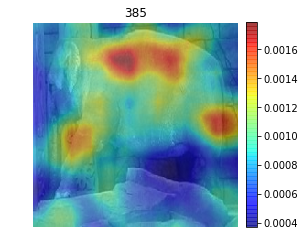

In [74]:
image, label = next(iter(Train_dataloader))
image = image.cuda()
saliency = explainer(image)
output = model(image)
cl = torch.argmax(output).item()

imshow(image[0], str(cl))
plt.imshow(saliency[cl], cmap='jet', alpha=0.5)
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()